In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin


# gpd.version.version

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(os.getcwd())

B:\GitRepos\onhm-fetcher-parser\notebooks


# Open Gridmet max temperature with geopandas and plot

In [3]:
print(os.getcwd())
from pathlib import Path
# folder = Path(r'../Data') # assumes working directory is onhm-fetcher-parser
folder = Path(r'../Data_v1_1') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

B:\GitRepos\onhm-fetcher-parser\notebooks
..\Data_v1_1
            GM_LAYER         LAYER            GM_TYPE  OBJECTID  hru_segmen  \
0       NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type         1        1551   
1       NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type         2        1551   
2       NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type         3        1547   
3       NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type         3        1547   
4       NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type         4        1555   
...              ...           ...                ...       ...         ...   
140767  NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type    114951         294   
140768  NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type    114952         285   
140769  NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type    114953         226   
140770  NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type    114954         294   
140771  NHM\nhru_v11  NHM\nhru_v11  Unknown Area Type    114955         115 

# Open Gridmet data (as netcdf file) print out some metadata
This first bit of code follows examples from the following link:https://climate.northwestknowledge.net/MACA/OPENDAP.php
First we open the data set and inspect the metadata

In [4]:
#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
# dirPath='http://thredds.northwestknowledge.net:8080'
# fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'
dirPath = 'tmax_test2.nc'
#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
# fullfilename= dirPath+fileName
fullfilename= dirPath
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', ds.attrs)
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
datahandle=ds['air_temperature']
crshandle=ds['crs']
print('\n The crs meta data is \n', crshandle.attrs)
print(datahandle)
# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n',datahandle.attrs)
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)

ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)

# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

tmax_test2.nc
<xarray.Dataset>
Dimensions:                  (time: 1, x: 5904, y: 3377)
Coordinates:
  * y                        (y) float32 1687.0 1686.0 ... -1688.0 -1689.0
  * x                        (x) float32 -2650.25 -2649.25 ... 3251.75 3252.75
  * time                     (time) datetime64[ns] 2018-12-31
Data variables:
    lat                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
    lon                      (y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    _NCProperties:       version=1|netcdflibversion=4.4.1|hdf5libversion=1.8.17
    start_year:          1980
    source:              Daymet Software Version 3.0
    Version_software:    Daymet S

KeyError: 'day'

In [5]:
print(datahandle[dayshape-1, 480, 1232])

<xarray.DataArray 'air_temperature' ()>
array(nan, dtype=float32)
Coordinates:
    lat      float64 29.4
    day      datetime64[ns] 2019-08-27
    lon      float64 -73.43
Attributes:
    units:              K
    description:        Daily Maximum Temperature
    long_name:          tmmx
    standard_name:      tmmx
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    _ChunkSizes:        [ 48 117 278]


# Add netcdf data (tmax here) to dataframe that has hru id and geometry
* use weight file to assign tmax

In [6]:
def testnan(value, weight):
    if np.isnan(value): 
        tvalue = 0.0
        tweight = 0.0
    else:
        tvalue = value
        tweight = weight
    return tvalue, tweight
    

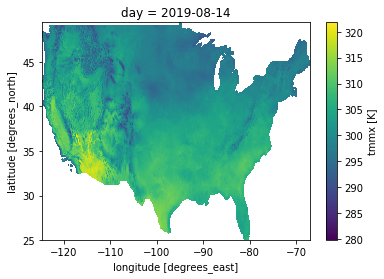

In [10]:
temp = ds.air_temperature
temp1 = temp.isel(day=225)
temp1.plot()

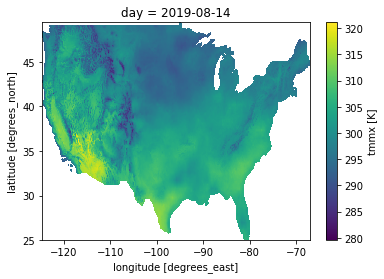

In [142]:
temp1.plot.pcolormesh("lon", 'lat')

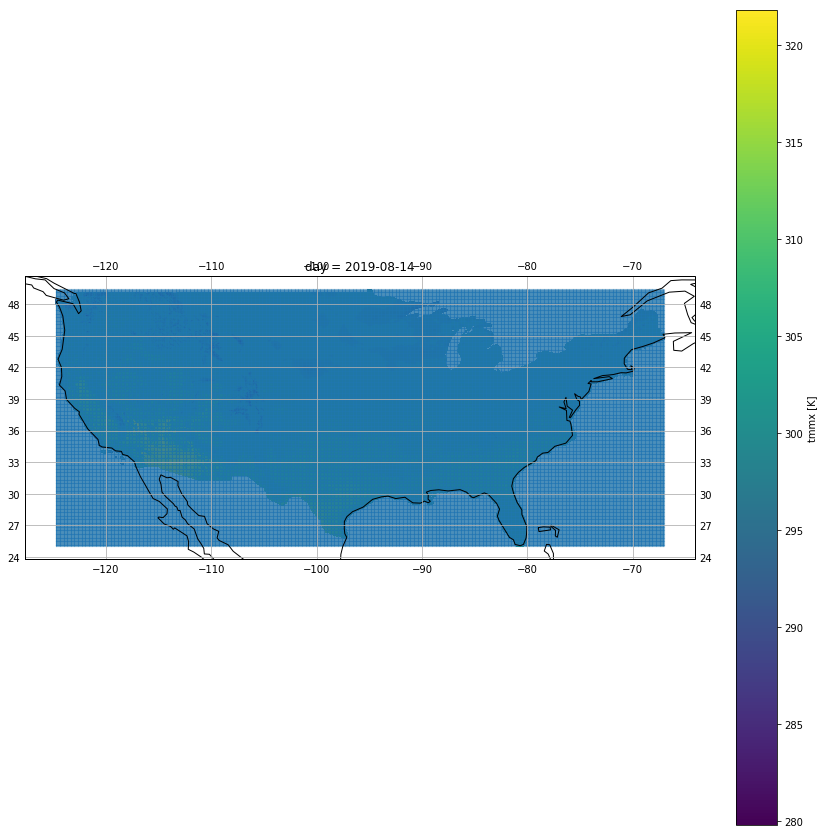

In [12]:
import cartopy.crs as ccrs
ax = plt.subplot(projection=ccrs.PlateCarree())
temp1.plot.pcolormesh('lon', 'lat', ax=ax)
lon, lat = np.meshgrid(lonhandle, lathandle)
ax.scatter(lon, lat, transform=ccrs.PlateCarree(),s=0.01)
ax.coastlines(); ax.gridlines(draw_labels=True)
fig = plt.gcf()
fig.set_size_inches(15,15)

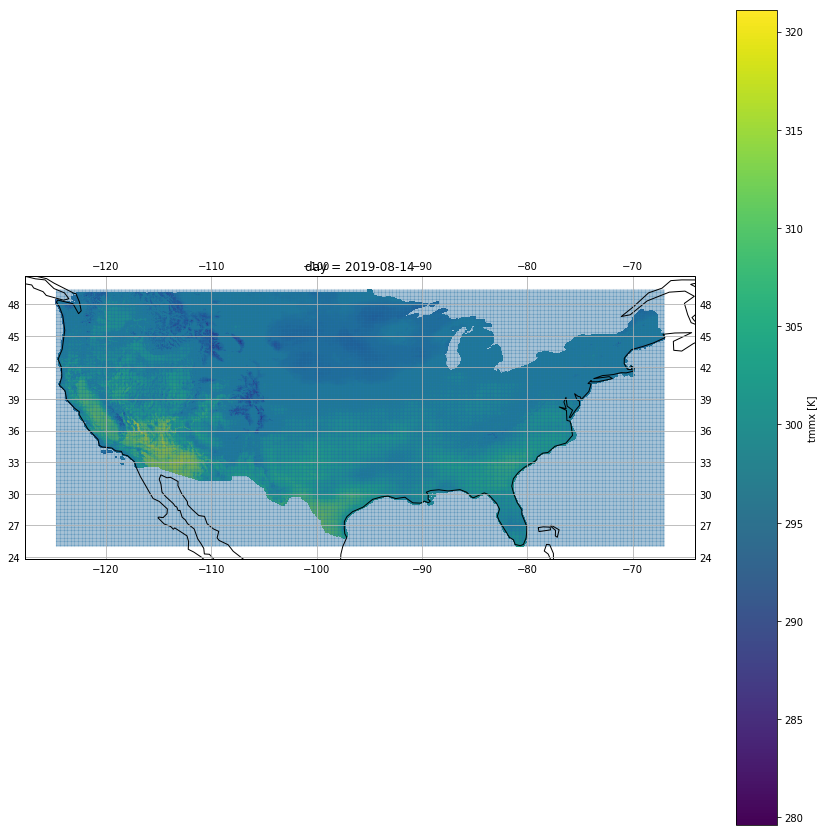

In [144]:
ax = plt.subplot(projection=ccrs.PlateCarree());
temp1.plot.pcolormesh('lon', 'lat', ax=ax, infer_intervals=True);
ax.scatter(lon, lat, transform=ccrs.PlateCarree(),s=0.001);
ax.coastlines(); ax.gridlines(draw_labels=True);
fig = plt.gcf()
fig.set_size_inches(15,15)

In [13]:
type(lat)
ndim(lat)
np.shape(lat)[0]
np.shape(lon)[0]
print(np.shape(temp1.values))
print(temp1.values.flatten())
# print(lat[0,0])
# print(npsize())

# for i in range(np.size(lathandle)):
#     print(lathandle[i])

(585, 1386)
[nan nan nan ... nan nan nan]


In [14]:
ds['crs']

<xarray.DataArray 'crs' (crs: 1)>
array([3.], dtype=float32)
Coordinates:
  * crs      (crs) float32 3.0
Attributes:
    grid_mapping_name:            latitude_longitude
    longitude_of_prime_meridian:  0.0
    semi_major_axis:              6378137.0
    long_name:                    WGS 84
    inverse_flattening:           298.257223563
    GeoTransform:                 -124.7666666333333 0.041666666666666 0  49....
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    _ChunkSizes:                  1

In [15]:
from shapely.geometry import Polygon
#first create dataframe with temp
df = pd.DataFrame({'temperature': temp1.values.flatten()})
res = 0.04166666/2.0
numcells = np.shape(lat)[0]*np.shape(lat)[1]
poly = []
index = np.zeros(numcells)
count = 0
# ncfcell = gpd.GeoDataFrame()
# ncfcell['geometry'] = None

for i in range(np.shape(lon)[0]):
    for j in range(np.shape(lon)[1]):
        lat_point_list = [lat[i,j]-res, lat[i,j]+res, lat[i,j]+res, lat[i,j]-res]
        lon_point_list = [lon[i,j]+res, lon[i,j]+res, lon[i,j]-res, lon[i,j]-res]
        poly.append(Polygon(zip(lon_point_list, lat_point_list)))
        index[count] = count
        count += 1
# ncfcells = gpd.GeoDataFrame(df, index=index, crs=ds['crs'], geometry=poly)  
ncfcells = gpd.GeoDataFrame(df, index=index, geometry=poly)  
ncfcells.head()

,temperature,geometry
0.0,NaN,"POLYGON ((-124.7458333033333 49.37916667, -124..."
1.0,NaN,"POLYGON ((-124.7041666366667 49.37916667, -124..."
2.0,NaN,"POLYGON ((-124.66249997 49.37916667, -124.6624..."
3.0,NaN,"POLYGON ((-124.6208333033333 49.37916667, -124..."
4.0,NaN,"POLYGON ((-124.5791666366667 49.37916667, -124..."


In [16]:
spatial_index = ncfcells.sindex
print(type(gdf.loc[[0]]))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [17]:
import csv
tcount = 0
with open('weights.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for index, row in gdf.iterrows():
        count = 0
        if tcount == 0:
            writer.writerow(['grid_ids', 'hru_id_nat', 'w'])
            possible_matches_index = list(spatial_index.intersection(row['geometry'].bounds))
            possible_matches = ncfcells.iloc[possible_matches_index]
            precise_matches = possible_matches[possible_matches.intersects(row['geometry'])]
            res_intersection = gpd.overlay(gdf.loc[[index]], precise_matches, how='intersection')
            for nindex, row in res_intersection.iterrows():
                tmpfloat = np.float(res_intersection.area.iloc[nindex]/gdf.loc[[index], 'geometry'].area)
                writer.writerow([np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), tmpfloat])
                count += 1
            tcount += 1
            print(tcount, index)
# f.close()        

1 0


In [149]:
import csv
tcount = 0
with open('weights.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for index, row in gdf.iterrows():
        count = 0
        if tcount == 0:
            writer.writerow(['grid_ids', 'hru_id_nat', 'w'])
        possible_matches_index = list(spatial_index.intersection(row['geometry'].bounds))
        possible_matches = ncfcells.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(row['geometry'])]
        res_intersection = gpd.overlay(gdf.loc[[index]], precise_matches, how='intersection')
        for nindex, row in res_intersection.iterrows():
            tmpfloat = np.float(res_intersection.area.iloc[nindex]/gdf.loc[[index], 'geometry'].area)
            writer.writerow([np.int(precise_matches.index[count]), np.int(row['hru_id_nat']), tmpfloat])
            count += 1
        tcount += 1
        print(tcount, index)
# f.close()        


1 0
2 1
3 2
4 3
5 4
6 5
7 6
8 7
9 8
10 9
11 10
12 11
13 12
14 13
15 14
16 15
17 16
18 17
19 18
20 19
21 20
22 21
23 22
24 23
25 24
26 25
27 26
28 27
29 28
30 29
31 30
32 31
33 32
34 33
35 34
36 35
37 36
38 37
39 38
40 39
41 40
42 41
43 42
44 43
45 44
46 45
47 46
48 47
49 48
50 49
51 50
52 51
53 52
54 53
55 54
56 55
57 56
58 57
59 58
60 59
61 60
62 61
63 62
64 63
65 64
66 65
67 66
68 67
69 68
70 69
71 70
72 71
73 72
74 73
75 74
76 75
77 76
78 77
79 78
80 79
81 80
82 81
83 82
84 83
85 84
86 85
87 86
88 87
89 88
90 89
91 90
92 91
93 92
94 93
95 94
96 95
97 96
98 97
99 98
100 99
101 100
102 101
103 102
104 103
105 104
106 105
107 106
108 107
109 108
110 109
111 110
112 111
113 112
114 113
115 114
116 115
117 116
118 117
119 118
120 119
121 120
122 121
123 122
124 123
125 124
126 125
127 126
128 127
129 128
130 129
131 130
132 131
133 132
134 133
135 134
136 135
137 136
138 137
139 138
140 139
141 140
142 141
143 142
144 143
145 144
146 145
147 146
148 147
149 148
150 149
151 150
152 151
15

0    1.292268e-07
1    3.345798e-05
2    9.682277e-04
3    5.001222e-05
4    2.208788e-05
dtype: float64 0.0010739150456825243 0    0.001074
dtype: float64


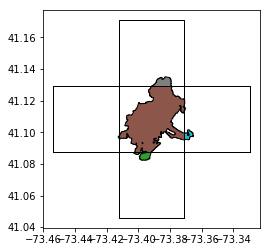

In [18]:
ax = res_intersection.plot(cmap='tab10')
ax = gdf.loc[[0], 'geometry'].plot(ax=ax, facecolor='none', edgecolor='k')
precise_matches.plot(ax=ax, facecolor='none', edgecolor='k')
print(res_intersection.area, np.sum(res_intersection.area), gdf.loc[[0], 'geometry'].area)

In [27]:
# print(res_intersection.head())
# print(shape(res_intersection))
# print(precise_matches.index[0])
print(precise_matches.iloc[0].temperature)
print(nindex)

299.8
4


In [43]:
print(precise_matches)

          temperature                                           geometry
278433.0   296.600006  POLYGON ((-73.37083330333334 41.04583333666667...
277046.0   296.600006  POLYGON ((-73.41249997000001 41.08750000333334...
277047.0   296.600006  POLYGON ((-73.37083330333334 41.08750000333334...
277048.0   296.500000  POLYGON ((-73.32916663666667 41.08750000333334...
275661.0   296.700012  POLYGON ((-73.37083330333334 41.12916667, -73....


In [ ]:
from shapely.strtree import STRtree
s = STRtree(poly)
for index, row in gdf.iterrows():
    tpoly = row['geometry']
    tbound = tpoly.bound


In [ ]:
import geoplot
geoplot.choropleth(ncfcells, hue='temperature', linewidth=0, k=None)

# Test with Pandas groupby alternative to original method in following cell

In [ ]:
# add tmax column to dataframe
gdf['tmax']=0.0

#open weight data
#wght_df = pd.read_csv('../Data/hru_metdata_weights.csv')
#wght_df_40 = pd.read_csv('../Data/hru_metdata_weights_40m.csv')
#wght_df_500 = pd.read_csv('../Data/hru_metdata_weights_500m.csv')
wght_UofI = pd.read_csv('../Data/hru_uofimetdata_weights.csv')
# print(len(wght_df['hru_id_nat'].unique()), len(wght_df_40['hru_id_nat'].unique()), 
#       len(wght_df_500['hru_id_nat'].unique()), len(wght_UofI['hru_id_nat'].unique()))
print(wght_UofI.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')
# ndata=np.nan_to_num(data)
print(ndata[1000:])
# def w_mean(data)
unique_hru_ids = wght_UofI.groupby('hru_id_nat')
print(len(gdf), len(unique_hru_ids))

def get_wval(grp, ndata):
    ttmax = twght = 0.0
    for index, row in grp.iterrows():
        ttmax += row['w']*ndata[np.int(row['grid_ids'])]
        twght += row['w']
    return ttmax/twght
def np_get_wval(grp, ndata):
    return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
#     return np.average(ndata[grp['grid_ids'].values.astype(int)], weights=grp['w'])
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
    weight_id_rows = unique_hru_ids.get_group(row['hru_id_nat'])
#     print(weight_id_rows['grid_ids'].values.astype(int))
#     unique_hru_ids.get_group(row['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})
#     gdf.loc[gdf.index[index],'tmax'] = np_get_wval(weight_id_rows, ndata)-273.5
    tmp = np_get_wval2(weight_id_rows, ndata)-273.5
    if index == 1:
        print(type(tmp))
    td[index] = np_get_wval2(weight_id_rows, ndata)-273.5
#     if td[index] < 0.0:
#         print(ndata[weight_id_rows['grid_ids'].values.astype(int)], weight_id_rows['w'])
#     print(index, td[index])
#     if row['hru_id_nat'] == 829:
#         print("in test")
#         for i2, el in weight_id_rows.iterrows():
#             print(el['w'], ndata[el['grid_ids'].astype(int)])
#         print(np.average(ndata[weight_id_rows['grid_ids'].values.astype(int)], weights=weight_id_rows['w'])-273.5)
#     print(index, row['hru_id_nat'], np_get_wval(weight_id_rows, ndata)-273.5)
#     gdf.loc[gdf.index[index], 'tmax'] =
# #     print(get_wval(weight_id_rows, ndata)-273.5)
# #     row.loc['tmax']=get_wval(weight_id_rows, ndata)-273.5
# #     gdf.loc[gdf.index[index], 'tmax'] = get_wval(weight_id_rows, ndata)-273.5
# print(len(td))
# gdf['tmax'] = gpd.GeoSeries([np.transpose(td)], index=gdf.index)
gdf['tmax'] = td.tolist()
gdf['tmax'].fillna(0.0)
# print(td.tolist())
print('min/max', gdf['tmax'].min(), gdf['tmax'].max())
# print(gdf)
# gdf.plot(figsize=(12,12), column = 'tmax',linewidth=0.25, edgecolor='white')    
# print(gdf.groupby(tmax).min)
f, ax = plt.subplots(2, figsize=(12,12))
gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white', scheme='quantiles')
ptmax = ds.air_temperature-273.5
ptmax_1 = ptmax.isel(day=dayshape-1)
lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

In [ ]:
gdf

In [ ]:
# add tmax column to dataframe
gdf['tmax']=None

#open weight data
wght_df = pd.read_csv('../Data/hru_metdata_weights.csv')
wght_df_40 = pd.read_csv('../Data/hru_metdata_weights_40m.csv')
wght_df_500 = pd.read_csv('../Data/hru_metdata_weights_500m.csv')
wght_UofI = pd.read_csv('../Data/hru_uofimetdata_weights.csv')
print(len(wght_df['hru_id_nat'].unique()), len(wght_df_40['hru_id_nat'].unique()), len(wght_df_500['hru_id_nat'].unique()))
print(wght_df.head())

#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
unique_hru_ids = wght_UofI['hru_id_nat'].unique()
print(len(gdf), len(unique_hru_ids))
ndata=datahandle.values[dayshape-1,:,:].flatten(order='C')
for index, row in gdf.iterrows():
    weight_id_rows = wght_UofI.loc[wght_UofI['hru_id_nat'] == row['hru_id_nat']]
    ttmax = 0.0
    twght = 0.0
    tcount = 0
    # based on above metadata the shape of the netcdf file is day,lat(y),lon(x)
    for ind2, rw2 in weight_id_rows.iterrows():
#           print(rw2['Y_ind'],rw2['X_ind'])
#         tval, twt = testnan(datahandle.values[dayshape-1,int(rw2['Y_ind']),int(rw2['X_ind'])], rw2['w'])
        tval, twt = testnan(ndata[rw2['grid_ids'].astype(int)], rw2['w'])
        if twt > 0.0:
            ttmax += twt*tval
            twght += twt
            tcount += 1
#           if index == 4512: # test that discovered some weights associated with intesecting cells that are outside conus and return nan values
#               print(ind2, rw2['w'], ttmax, twght, tcount, datahandle.values[dayshape-1,int(rw2['Y_ind']),int(rw2['X_ind'])], rw2['Y_ind'], rw2['X_ind'])
    print(index, row['hru_id_nat'], tcount, ttmax, twght, ((ttmax/twght)-273.15))
    gdf.loc[gdf.index[index], 'tmax'] = ((ttmax/twght)-273.15)
#         data.setvalue(index, 'tmax', ((ttmax/twght)-273.15) * 9/5 + 32)
#         print('tmp', hru_id, row['tmax'])
# print(gdf)
# gdf.plot()
# f, ax = plt.subplots(2, figsize=(8,6))
# gdf.plot(ax=ax[0], column = 'tmax')
# ptmax = ds.air_temperature-273.5
# ptmax_1 = ptmax.isel(day=dayshape-1)
# ptmax_1.plot(ax=ax[1], levels=20)

# Convert netcdf to geotiff

In [ ]:
lat = lathandle.values
lon = lonhandle.values

transform = from_origin( lonmin, latmax, lonres, latres)
# res = (lon[-1] - lon[0])/lon.shape[0]
# print(res)
# transform2 = from_origin(lon[0]-res/2, lat[-1]+res/2, res, res) 
# print(transform, transform2)
new_dataset = rasterio.open(r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip\test1.tif', 'w', driver='GTiff',
                            height = lonshape, width = latshape,
                            count=1, dtype=str(datahandle.dtype),
                            crs={'init': 'epsg:4326'},
                            transform=transform)
# vals = np.transpose(datahandle.values, [1,2,0])
# vals2 = vals[:,:,85-1]
vals = datahandle.values[dayshape-1, :, :]
print(vals.shape)
# im = np.transpose(vals, [1,2,0])
# fa = np.asfortranarray(vals)
# ca = np.asanyarray(vals, order='C')
ud = (np.flipud(vals)-273.15) * 9/5 + 32
# at = np.transpose(vals)
# atf = np.rot90(at)
new_dataset.write(ud, 1)
# new_dataset.warp.transform
# print(new_dataset.transform)
# pyplot.imshow(new_dataset.read(1), cmap='pink')
# pyplot.show()
print(new_dataset)
new_dataset.close()

# Plot geotiff raster data

In [ ]:
os.chdir(r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip')
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)
print(src)
plt.imshow(array, interpolation='nearest')
plt.colorbar()
plt.title('max temp')
plt.show()
src.close()

# Perform zonal stats using rasterstats with the geotiff raster and hru shapefile

In [ ]:
import geoplot as gplt

print(transform)
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)

hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, array, transform=transform.to_gdal(), prefix='tmax_', all_touched=True)
statsdf = pd.DataFrame(stats)
src.close()

print(statsdf.head())

zonalhru = hrudata.join(statsdf)

# # print(stats)
# # newhru = hrudata.join(gpd.DataFrame(stats))
# # print(newhru.head())
zonalhru.__class__ = gpd.GeoDataFrame
zonalhru.crs={}
zonalhru.set_geometry('geometry')
# ax = gplt.pointplot(zonalhru['mean'])
# gplt.polyplot()
# geoplot.choropleth(zonalhru, hue='mean', cmap='viridis', k = 20, 
#                 linewidth=0.5, legend=True)
zonalhru.plot(column='tmax_mean', cmap='viridis')

# Alternative Rasterstats method: 
* https://geohackweek.github.io/vector/06-geopandas-advanced/

In [ ]:
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

# print(transform)
with rasterio.open(r'test1.tif') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
rasterdata = rasterio.open(r'test1.tif')
tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, r'test1.tif', transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

In [ ]:
print(len(stats_gdf.index))

# write netcdf file using netcdf4
* https://github.com/Unidata/netcdf4-python/blob/master/examples/writing_netCDF.ipynb

In [ ]:
import netCDF4
try: ncfile.close() # just to be safe, make sure dataset is not already open.
except: pass
ncfile = netCDF4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC')

# Global Attributes
ncfile.Conventions = 'CF-1.8'
ncfile.featureType = 'timeSeries'
ncfile.history = ''

sp_dim = len(stats_gdf.index)
hruid_dim = ncfile.createDimension('hruid', sp_dim)     # hru_id
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

#Create Variables
time = ncfile.createVariable('time', np.int, ('time', ))
time.long_name = 'time'
time.standard_name = 'time'
time.units = 'days since '+'base_date'+' 00:00'+'time_zone'

hru = ncfile.createVariable('hruid', np.int, ('hruid', ))
hru.cf_role = 'timeseries_id'
hru.long_name = 'local model hru id'

lat = ncfile.createVariable('hru_lat', np.float32, ('hruid',))
lat.long_name = 'Latitude of HRU centroid'
lat.units = 'degrees_north'
lat.standard_name = 'hru_latitude'

lon = ncfile.createVariable('hru_lon', np.float32, ('hruid',))
lon.long_name = 'Longitude of HRU centroid'
lon.units = 'degrees_east'
lon.standard_name = 'hru_longitude'

prcp = ncfile.createVariable('prcp', np.float32, ('time', 'hruid'))
prcp.long_name = 'Daily precipitation rate'
prcp.units = 'mm/day'
prcp.standard_name = 'lwe_precipitation_rate'

tmax = ncfile.createVariable('tmax', np.float32, ('time', 'hruid'))
tmax.long_name = 'Maximum daily air temperature'
tmax.units = 'degree_Celsius'
tmax.standard_name = 'maximum_daily_air_temperature'

tmin = ncfile.createVariable('tmin', np.float32, ('time', 'hruid'))
tmin.long_name = 'Minimum daily air temperature'
tmin.units = 'degree_Celsius'
tmin.standard_name = 'minimum_daily_air_temperature'

# fill variables with available data
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = stats_gdf['geometry'].centroid
tlon, tlat = [list(t) for t  in zip(*map(getXY, centroidseries))]
# print(lon, lat)
lon[:] = tlon
lat[:] = tlat
hru[:] = stats_gdf['hru_id_nat'].values
# print(hruid)
tmax[0,:] = stats_gdf['tmax_mean'].values

print(ncfile)
ncfile.close(); print("dataset is closed")
